### Download required datas and packages

In [1]:
# download data
!wget https://www.dropbox.com/s/l3n50dgx2134g0e/hw3_data.zip?dl=1 -O hw3_data.zip
!unzip hw3_data.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: hw3_data/p2_data/images/train/000000226677.jpg  
  inflating: __MACOSX/hw3_data/p2_data/images/train/._000000226677.jpg  
  inflating: hw3_data/p2_data/images/train/2832654970.jpg  
  inflating: __MACOSX/hw3_data/p2_data/images/train/._2832654970.jpg  
  inflating: hw3_data/p2_data/images/train/000000343951.jpg  
  inflating: __MACOSX/hw3_data/p2_data/images/train/._000000343951.jpg  
  inflating: hw3_data/p2_data/images/train/000000531622.jpg  
  inflating: __MACOSX/hw3_data/p2_data/images/train/._000000531622.jpg  
  inflating: hw3_data/p2_data/images/train/000000176946.jpg  
  inflating: __MACOSX/hw3_data/p2_data/images/train/._000000176946.jpg  
  inflating: hw3_data/p2_data/images/train/000000147543.jpg  
  inflating: __MACOSX/hw3_data/p2_data/images/train/._000000147543.jpg  
  inflating: hw3_data/p2_data/images/train/000000273138.jpg  
  inflating: __MACOSX/hw3_data/p2_data/images/train/._000000273138.jpg  
  inflating: hw3_data/p2_data/images/t

In [2]:
# download required packages 
!pip install timm
!pip install tokenizers
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 4.8 MB/s 
     |████████████████████████████████| 182 kB 67.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 4.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-u79ys5_4
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-u79ys5_4
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=95a2a9bfd298b3db7a1e5695420847ada91cf755db39cad4789c1683d6c13baa
  Stored in directory: /tmp/pip-ephem-wheel-cache-fqn1ezi3/w

### import packages

In [3]:
import os
import sys
import glob
import copy
import math
import random

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch import optim
import torchvision
import torchvision.models as models
import torchvision.transforms as T

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from tokenizers import Tokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
# set seed
seed = 4956238
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### clip model and data transform

In [4]:
import clip
model_vit, preprocess = clip.load("ViT-L/14", device=device)

100%|███████████████████████████████████████| 890M/890M [00:16<00:00, 57.4MiB/s]


### Dataset

In [5]:
from torch import Tensor
tokenizer = Tokenizer.from_file('hw3_data/caption_tokenizer.json')
def create_masks(features, pad_token=0, is_tgt_masking=False):
    masks = (features == pad_token)
    if is_tgt_masking:
        size = features.size(1)
        nopeak_mask = np.triu(np.ones((1, size, size)), k=1).astype('uint8')
        nopeak_mask = torch.from_numpy(nopeak_mask) == 0
        masks = masks.unsqueeze(1) & nopeak_mask
    
    return masks  

class Caption_Dataset(Dataset):
    def __init__(self, root, json_file, tfm=None, max_len=64):
        super(Caption_Dataset, self).__init__()
        with open(json_file) as f:
            data = json.load(f)
        # data:
        #   annotations: caption, id, image_id
        #   images: id, file_name
        self.img_id_pair = {}
        for i in range(len(data['images'])):
            tmp = data['images'][i]
            self.img_id_pair[str(tmp['id'])] = tmp['file_name']
        self.datas = data['annotations']
        self.root = root
        self.tfm = tfm
        self.max_len = max_len
        self.len = len(data['annotations'])
    def __len__(self):
        return self.len
    def __getitem__(self, idx):
        tmp = self.datas[idx]
        caption = tmp['caption']
        caption = tokenizer.encode(caption).ids
        img_id = self.img_id_pair[str(tmp['image_id'])]
        img = Image.open(os.path.join(self.root, img_id)).convert('RGB')
        img = self.tfm(img)
        cap_in = torch.randint(0, 1, (self.max_len,))
        cap_out = torch.randint(0, 1, (self.max_len,))
        cap_in[:len(caption)-1] = torch.tensor(caption[:-1])
        cap_out[:len(caption)-1] = torch.tensor(caption[1:])
        
        return img, cap_in, cap_out, create_masks(cap_in)

### test for training set

53046


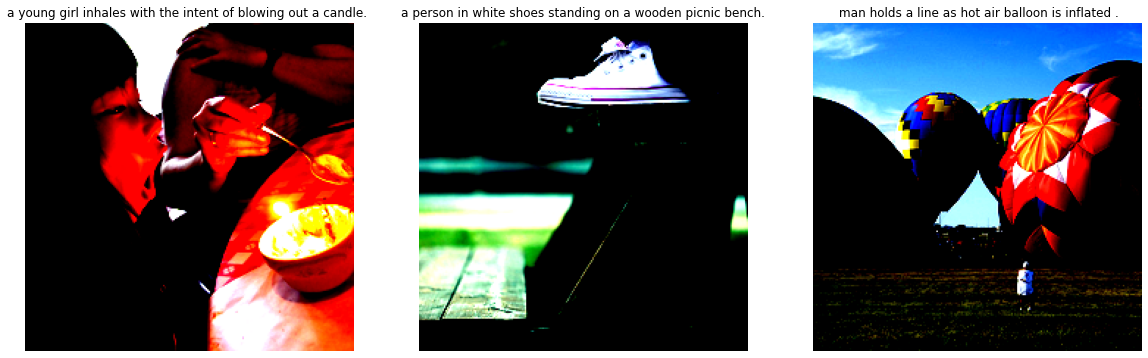

In [6]:
import gc
import torchvision.transforms.functional as TF

tfm = T.Compose([T.Resize((384, 384), interpolation=TF.InterpolationMode.BICUBIC),
                 T.CenterCrop(384),
                 T.ToTensor(), 
                 T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

json_file='hw3_data/p2_data/train.json'
train_dataset = Caption_Dataset(root='hw3_data/p2_data/images/train',
                                json_file=json_file,
                                tfm=preprocess)
print(len(train_dataset))
with open(json_file) as f:
    data = json.load(f)
datas = data['annotations']
rand = [0, 20000, 50000]
# rand = [0, 1000, 4000]
num = len(rand)
plt.figure(figsize=(20, 60))
for i in range(num):
    tmp = train_dataset[rand[i]]
    img = tmp[0].permute(1, 2, 0).numpy()
    cap = datas[rand[i]]['caption']
    plt.subplot(1, num, i+1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(cap)


### test for validation set

8946


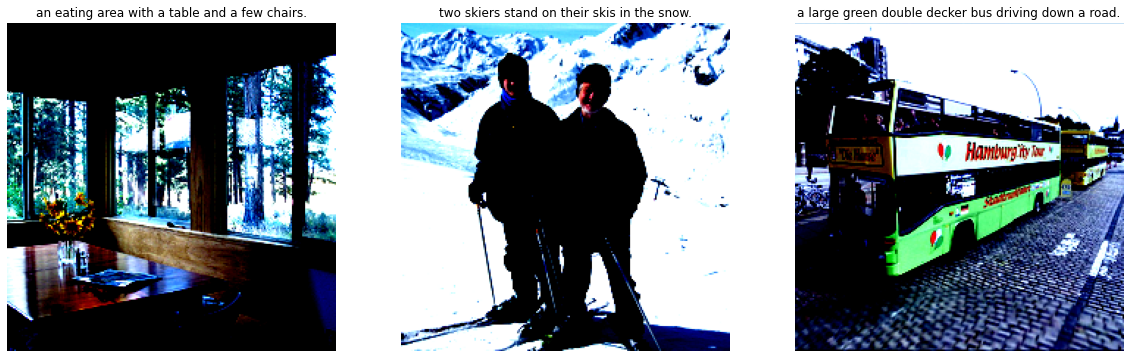

In [7]:
json_file='hw3_data/p2_data/val.json'
val_dataset = Caption_Dataset(root='hw3_data/p2_data/images/val',
                                json_file=json_file,
                                tfm=preprocess)
print(len(val_dataset))
with open(json_file) as f:
    data = json.load(f)
datas = data['annotations']
# rand = [0, 20000, 50000]
rand = [0, 1000, 4000]
num = len(rand)
plt.figure(figsize=(20, 60))
for i in range(num):
    tmp = val_dataset[rand[i]]
    img = tmp[0].permute(1, 2, 0).numpy()
    cap = datas[rand[i]]['caption']
    plt.subplot(1, num, i+1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(cap)


### construct model


In [8]:
class Embeddings(nn.Module):
    """
    Word Embeddings after Tokenized
    :input:
        model_dim:    one token embedding shape
        vocab_size:   vocabulary size
    
    :output:
        embeddings shape [batch * input length * model_dim]
    """
    def __init__(self, vocab_size, model_dim):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab_size, model_dim)
        self.model_dim = model_dim

    def forward(self, x):
        """
        x: tokenized [batch size * text length]
        """
        return self.lut(x) * math.sqrt(self.model_dim)

class PositionalEncoding(nn.Module):
    """
    Positional Encoding to add information to Embeddings
    :input:
        model_dim:      one token embedding shape
        dropout_rate:   dropout prob
    :output:
        encoded embeddings shape [batch * input length * model_dim]
    """
    def __init__(self, model_dim, dropout_rate, max_len=64):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2) *
                             -(math.log(10000.0) / model_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        """
        Add additional positional information to embedding
        x: [batch * text length * model_dim]
        """
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [22]:
TIMM_MODELS = [
        "deit_tiny_distilled_patch16_224", 
        'deit_small_distilled_patch16_224', 
        'deit_base_distilled_patch16_224',
        'deit_base_distilled_patch16_384']

def get_pretrained_encoder(model_name):
    import timm
    assert model_name in TIMM_MODELS, "Timm Model not found"
    model = timm.create_model(model_name, pretrained=True)
    return model

def get_clones(module, N):
    """
    "Produce N identical layers."
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
def init_xavier(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)


class EncoderVIT(nn.Module):
    """
    Pretrained Transformers Encoder from timm Vision Transformers
    :output:
        encoded embeddings shape [batch * (image_size/patch_size)**2 * model_dim]
    """
    def __init__(self, model=None):
        super().__init__()
        
        vit = model
        self.conv1 = vit.conv1
        self.class_embedding = vit.class_embedding
        self.positional_embedding = vit.positional_embedding
        self.ln_pre = vit.ln_pre
        self.ln_post = vit.ln_post
        self.transformer = vit.transformer
        self.proj = vit.proj
        
    def forward(self, x):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 1:, :])

        if self.proj is not None:
            x = x @ self.proj

        return x

class EncoderVIT2(nn.Module):
    """
    Pretrained Transformers Encoder from timm Vision Transformers
    :output:
        encoded embeddings shape [batch * (image_size/patch_size)**2 * model_dim]
    """
    def __init__(self, model_name='deit_base_distilled_patch16_384'):
        super().__init__()
        
        vit = get_pretrained_encoder(model_name)
        self.embed_dim = vit.embed_dim 
        self.patch_embed = vit.patch_embed
        self.pos_embed = vit.pos_embed
        self.pos_drop = vit.pos_drop
        self.blocks = vit.blocks
        self.norm = vit.norm
        
    def forward(self, src):
        x = self.patch_embed(src)
        x = self.pos_drop(x + self.pos_embed[:, 2:]) # skip dis+cls tokens
        x = self.blocks(x)
        x = self.norm(x)
        return x


class DecoderLayer(nn.Module):
    """
    A single decoder layer use Masked Multihead, Multihead Attention, 
    2 layer feed forward, Layer Normalization and Dropout
    """
    def __init__(self, d_model, d_ff, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)
        self.norm_3 = nn.LayerNorm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = nn.MultiheadAttention(d_model, heads, dropout=dropout, batch_first=True)
        self.attn_2 = nn.MultiheadAttention(d_model, heads, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x, e_outputs, src_mask, trg_mask, trg_attn_mask):
        x2 = self.norm_1(x)

        # Decoder self-attention
        x2, _ = self.attn_1(x2, x2, x2, key_padding_mask=trg_mask, attn_mask=trg_attn_mask)
        x = x + self.dropout_1(x2)
        x2 = self.norm_2(x)

        # Encoder Decoder attention
        x2, _ = self.attn_2(x2, e_outputs, e_outputs, key_padding_mask=src_mask)
        x = x + self.dropout_2(x2)
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x

class Decoder(nn.Module):
    """
    Decoder with N-stacked DecoderLayers
    :input:
        vocab_size:     size of target vocab
        d_model:        embeddings dim
        d_ff:           feed-forward dim
        N:              number of layers
        heads:          number of attetion heads
        dropout:        dropout rate
    :output:
        decoded embeddings shape [batch * input length * model_dim]
    """
    def __init__(self, vocab_size, d_model, d_ff, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embeddings(vocab_size, d_model)
        self.pe = PositionalEncoding(d_model, dropout_rate=dropout)
        self.layers = get_clones(DecoderLayer(d_model, d_ff, heads, dropout), N)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask, trg_attn_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask, trg_attn_mask)
        return self.norm(x)

class Transformer(nn.Module):
    """
    Transformer model
    :input:
        patch_size:    size of patch
        trg_vocab:     size of target vocab
        d_model:       embeddings dim
        d_ff:          feed-forward dim
        N:             number of layers
        heads:         number of attetion heads
        dropout:       dropout rate
    :output:
        next words probability shape [batch * input length * vocab_dim]
    """
    def __init__(self, trg_vocab=18022, d_model=768, d_ff=2048, N_dec=4, heads=8, dropout=0.1, model=None):
        super().__init__()

        self.encoder = EncoderVIT(model=model)
        for params in self.encoder.parameters():
            params.requires_grad = False

        self.decoder = Decoder(trg_vocab, d_model, d_ff, N_dec, heads, dropout)
        self.out = nn.Sequential(
            nn.Linear(d_model, trg_vocab),
            nn.LogSoftmax(dim=-1)
        )
        init_xavier(self.decoder)
        init_xavier(self.out)

    def forward(self, src, trg, src_mask, trg_mask, trg_attn_mask, *args, **kwargs):
        e_outputs = self.encoder(src)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask, trg_attn_mask)
        output = self.out(d_output)
        return output
        
    # def predict(
    #     self, src_inputs, src_masks, 
    #     tokenizer, max_len=None, 
    #     top_k = 5, top_p=0.9, temperature = 0.9,
    #     *args, **kwargs):

    #     """
    #     Inference step
    #     """

    #     if max_len is None:
    #         max_len = src_inputs.shape[-1]

    #     # sampling_search, beam_search
    #     # outputs = sampling_search(
    #     #     self, 
    #     #     src=src_inputs, 
    #     #     src_mask=src_masks, 
    #     #     max_len=max_len, 
    #     #     top_k = top_k, top_p=top_p, 
    #     #     temperature = temperature,
    #     #     tokenizer=tokenizer)

    #     outputs = beam_search(
    #         self, 
    #         src=src_inputs, 
    #         src_mask=src_masks,
    #         tokenizer=tokenizer, 
    #         max_len=max_len, k=3, alpha=0.7)

    #     return outputs

class Transformer2(nn.Module):
    """
    Transformer model
    :input:
        patch_size:    size of patch
        trg_vocab:     size of target vocab
        d_model:       embeddings dim
        d_ff:          feed-forward dim
        N:             number of layers
        heads:         number of attetion heads
        dropout:       dropout rate
    :output:
        next words probability shape [batch * input length * vocab_dim]
    """
    def __init__(self, trg_vocab=18022, d_model=768, d_ff=2048, N_enc=12, N_dec=3, heads=8, dropout=0.15, pretrained_encoder=True):
        super().__init__()

        self.encoder = EncoderVIT2()
        # Override decoder hidden dim if use pretrained encoder
        d_model = self.encoder.embed_dim
        for params in self.encoder.parameters():
            params.requires_grad = False

        self.decoder = Decoder(trg_vocab, d_model, d_ff, N_dec, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)

        if pretrained_encoder:
            init_xavier(self.decoder)
            init_xavier(self.out)
        else:
            init_xavier(self)

    def forward(self, src, trg, src_mask, trg_mask, *args, **kwargs):
        e_outputs = self.encoder(src)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

In [23]:
arg = {
    'data_dir': 'hw3_data/p2_data',
    'save_dir': 'drive/MyDrive/hw3',
    'n_epoch': 100,
    'batch_size': 256,
    'lr': 1e-5,
    'weight_decay': 1e-6,
    'img_size': 224,
    'max_len': 256
}

In [24]:
import gc

print(device)
print('train set:', len(train_dataset))
print('validation set:', len(val_dataset))

train_loader = DataLoader(train_dataset, batch_size=arg['batch_size'], shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=arg['batch_size'], shuffle=False, num_workers=6)

model = Transformer(model=model_vit.visual).type(torch.FloatTensor).to(device)
# model = Transformer2().type(torch.FloatTensor).to(device)
model.load_state_dict(torch.load(os.path.join(arg['save_dir'], 'model2.pth')))
model.type(torch.FloatTensor).to(device)
model.eval()

# optimizer = torch.optim.Adam(model.parameters(), lr=arg['lr'], eps=1e-9, weight_decay=arg['weight_decay'], betas=(0.5, 0.999))
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)
gc.collect()

cuda
train set: 53046
validation set: 8946


1162

In [25]:
def generate_square_subsequent_mask(sz: int) -> Tensor:
    r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
        Unmasked positions are filled with float(0.0).
    """
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [26]:
import progressbar

model.train()
# tmp_val = sys.maxsize 
tmp_val = 2.61272
n_epoch = arg['n_epoch']
# n_epoch = 1
attn_mask = generate_square_subsequent_mask(64).to(device)

for epoch in range(n_epoch):
    model.train()
    model.type(torch.FloatTensor).to(device)
    train_loss = []
    progress = tqdm(train_loader)
    for batch in progress:
        model.train()
        img, cap_in, cap_out, trg_mask = batch
        img, cap_in, cap_out, trg_mask = img.to(device), cap_in.to(device), cap_out.to(device), trg_mask.to(device)
        optimizer.zero_grad()
        bs = img.shape[0]
        src_mask = torch.ones(bs, arg['max_len']).to(device)
        out = model(img, cap_in, src_mask, trg_mask, attn_mask)
        loss = criterion(out.contiguous().view(-1, out.size(-1)), cap_out.view(-1))
        loss.backward()
        nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=0.1)
        optimizer.step()
        train_loss.append(loss.item())
        progress.set_postfix(loss=loss.item())
    training_loss = sum(train_loss) / len(train_loss)
    print(f'[ Train | {epoch + 1:03d}/{n_epoch:03d} ] loss = {training_loss:.5f}')
    
    if (epoch + 1) == 10:
        for param in optimizer.param_groups:
            param['lr'] = param['lr'] * 0.5

    model.eval()
    val_loss = []
    progress2 = tqdm(val_loader)
    for batch in progress2:
        img, cap_in, cap_out, trg_mask = batch
        img, cap_in, cap_out, trg_mask = img.to(device), cap_in.to(device), cap_out.to(device), trg_mask.to(device)
        bs = img.shape[0]
        src_mask = torch.ones(bs, arg['max_len']).to(device)
        with torch.no_grad():
            out = model(img, cap_in, src_mask, trg_mask, attn_mask)
        loss = criterion(out.contiguous().view(-1, out.size(-1)), cap_out.view(-1))
        val_loss.append(loss.item())
        progress2.set_postfix(loss=loss.item())
    val_loss = sum(val_loss) / len(val_loss)
    print(f'[ validation | {epoch + 1:03d}/{n_epoch:03d} ] loss = {val_loss:.5f}')

    if val_loss < tmp_val:
        print('save the model!')
        torch.save(model.type(torch.HalfTensor).state_dict(), os.path.join(arg['save_dir'], 'model2.pth'), _use_new_zipfile_serialization=False)
        tmp_val = val_loss

100%|██████████| 208/208 [10:53<00:00,  3.14s/it, loss=1.89]


[ Train | 001/100 ] loss = 1.99765


100%|██████████| 35/35 [01:44<00:00,  3.00s/it, loss=3.03]


[ validation | 001/100 ] loss = 2.61354


  0%|          | 0/208 [00:01<?, ?it/s]


KeyboardInterrupt: ignored

In [27]:
class ImgDataset(Dataset):
    def __init__(self, path, tfm=None, files=None):
        super(ImgDataset).__init__()
        self.path = path
        self.files = sorted(glob.glob(os.path.join(path, '*')))
        self.transform = tfm

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]
        img = Image.open(file_name).convert('RGB')
        img = self.transform(img)
        return img

In [28]:
data = ImgDataset('/content/hw3_data/p2_data/images/val', tfm=preprocess)
files_name = data.files
files_name = [f.split('/')[-1].split('.')[0] for f in files_name]
print(files_name)
val_loader = DataLoader(data, batch_size=1, shuffle=False)

['000000000368', '000000000620', '000000001548', '000000001999', '000000002982', '000000003461', '000000003771', '000000003999', '000000004956', '000000005418', '000000005434', '000000005757', '000000005811', '000000006393', '000000006789', '000000007201', '000000008320', '000000009214', '000000009813', '000000010217', '000000010496', '000000011182', '000000011323', '000000011613', '000000012103', '000000013169', '000000013414', '000000013506', '000000013844', '000000013938', '000000014475', '000000014726', '000000014941', '000000014985', '000000015733', '000000015797', '000000015984', '000000016520', '000000017167', '000000018183', '000000018467', '000000019491', '000000019754', '000000019797', '000000020147', '000000020172', '000000020972', '000000021374', '000000022051', '000000022198', '000000022440', '000000022478', '000000022979', '000000023051', '000000023603', '000000024100', '000000024454', '000000025353', '000000025516', '000000026162', '000000026294', '000000026501', '000000

In [29]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    # attn_shape = (1, size, size)
    attn_shape = (size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 1
print(subsequent_mask(3))

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])


In [30]:
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=6)
model.load_state_dict(torch.load(os.path.join(arg['save_dir'], 'model2.pth')))
model.type(torch.FloatTensor).to(device)
model.eval()
result = {}
for i, batch in enumerate(tqdm(val_loader)):
    img = batch.to(device)
    x_patch = torch.ones(1, 256).to(device)
    memory = model.encoder(img)
    ys = torch.zeros(1, 1).long().to(device)
    ys[:] = 2
    max_len = 64
    ans = []
    for j in range(max_len-1):
        y_patch = torch.zeros(1, ys.shape[1]).to(device)
        with torch.no_grad():
            out = model.decoder(ys, memory, x_patch, y_patch, subsequent_mask(ys.shape[1]).to(device))
            out = model.out(out[:, -1])
        next_word = out.argmax(dim=-1).item()
        ans.append(next_word)
        ys = torch.cat([ys, torch.empty(1, 1).type_as(ys.data).fill_(next_word)], dim=1).to(device)
        if next_word == 13:
            break
        # break
    # print(tokenizer.decode(ans))
    # plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu().numpy())
    # print(label)
    result[str(files_name[i])] = tokenizer.decode(ans)



json_object = json.dumps(result, indent=4)
with open("sample2.json", "w") as outfile:
    outfile.write(json_object)

100%|██████████| 1789/1789 [03:33<00:00,  8.39it/s]


In [31]:
!pip install git+https://github.com/bckim92/language-evaluation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/bckim92/language-evaluation.git to /tmp/pip-req-build-9y0t91hl
  Running command git clone -q https://github.com/bckim92/language-evaluation.git /tmp/pip-req-build-9y0t91hl
  Created wheel for language-evaluation: filename=language_evaluation-0.1.0-py3-none-any.whl size=42700525 sha256=7961b73d5f629a4a701b762cf604d8fdf38e38430db09f8efc20187c182b84d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-f_jl8njy/wheels/4a/4d/4a/a5f2dac9261828f9639df19b8d87b4ed4effcfda88f9155bf2
Successfully built language-evaluation


In [32]:
# python3 p2_evaluate.py --pred_file <output_json_file_path> --images_root <image_folder_path> --annotation_file <annotation_json_file_path>
!python3 p2_evaluate.py --pred_file '/content/sample2.json' --images_root '/content/hw3_data/p2_data/images/val' --annotation_file '/content/hw3_data/p2_data/val.json'

python3: can't open file 'p2_evaluate.py': [Errno 2] No such file or directory


In [33]:
data = ImgDataset('/content/hw3_data/p3_data/images', tfm=preprocess)
files_name = data.files
files_name2 = [f.split('/')[-1].split('.')[0] for f in files_name]
print(files_name)
print(files_name2)
val_loader = DataLoader(data, batch_size=1, shuffle=False)

['/content/hw3_data/p3_data/images/bike.jpg', '/content/hw3_data/p3_data/images/girl.jpg', '/content/hw3_data/p3_data/images/sheep.jpg', '/content/hw3_data/p3_data/images/ski.jpg', '/content/hw3_data/p3_data/images/umbrella.jpg']
['bike', 'girl', 'sheep', 'ski', 'umbrella']


In [35]:
def get_clones(module, N):
    """
    "Produce N identical layers."
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
def init_xavier(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

class EncoderVIT(nn.Module):
    def __init__(self, model=None):
        super().__init__()
        
        vit = model
        self.conv1 = vit.conv1
        self.class_embedding = vit.class_embedding
        self.positional_embedding = vit.positional_embedding
        self.ln_pre = vit.ln_pre
        self.ln_post = vit.ln_post
        self.transformer = vit.transformer
        self.proj = vit.proj
        
    def forward(self, x):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 1:, :])

        if self.proj is not None:
            x = x @ self.proj

        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)
        self.norm_3 = nn.LayerNorm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = nn.MultiheadAttention(d_model, heads, dropout=dropout, batch_first=True)
        self.attn_2 = nn.MultiheadAttention(d_model, heads, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x, e_outputs, src_mask, trg_mask, trg_attn_mask):
        x2 = self.norm_1(x)

        # Decoder self-attention
        x2, _ = self.attn_1(x2, x2, x2, key_padding_mask=trg_mask, attn_mask=trg_attn_mask)
        x = x + self.dropout_1(x2)
        x2 = self.norm_2(x)

        # Encoder Decoder attention
        x2, attn_weight = self.attn_2(x2, e_outputs, e_outputs, key_padding_mask=src_mask)
        x = x + self.dropout_2(x2)
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x, attn_weight

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embeddings(vocab_size, d_model)
        self.pe = PositionalEncoding(d_model, dropout_rate=dropout)
        self.layers = get_clones(DecoderLayer(d_model, d_ff, heads, dropout), N)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask, trg_attn_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x, attn_weight = self.layers[i](x, e_outputs, src_mask, trg_mask, trg_attn_mask)
        return self.norm(x), attn_weight

class Transformer(nn.Module):
    def __init__(self, trg_vocab=18022, d_model=768, d_ff=2048, N_dec=4, heads=8, dropout=0.1, model=None):
        super().__init__()

        self.encoder = EncoderVIT(model=model)
        for params in self.encoder.parameters():
            params.requires_grad = False

        self.decoder = Decoder(trg_vocab, d_model, d_ff, N_dec, heads, dropout)
        self.out = nn.Sequential(
            nn.Linear(d_model, trg_vocab),
            nn.LogSoftmax(dim=-1)
        )
        init_xavier(self.decoder)
        init_xavier(self.out)

    def forward(self, src, trg, src_mask, trg_mask, trg_attn_mask, *args, **kwargs):
        e_outputs = self.encoder(src)
        d_output, attn_weight = self.decoder(trg, e_outputs, src_mask, trg_mask, trg_attn_mask)
        output = self.out(d_output)
        return output, attn_weight

  0%|          | 0/5 [00:00<?, ?it/s]

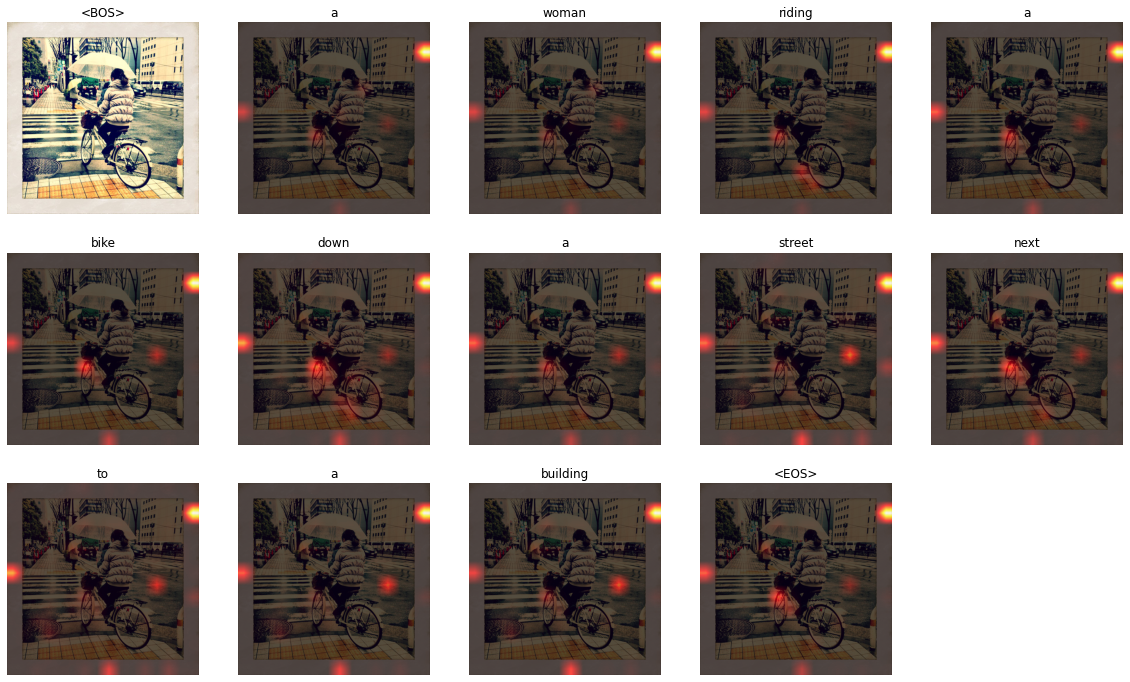

 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

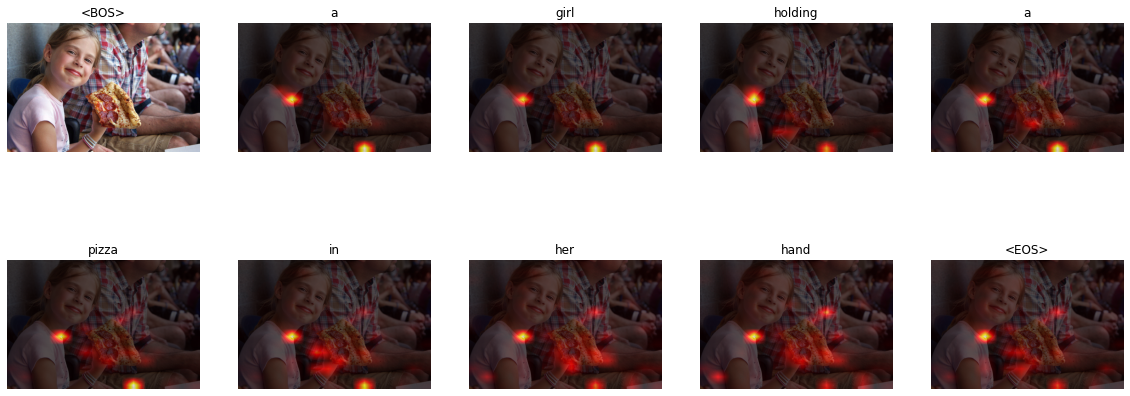

 40%|████      | 2/5 [00:03<00:05,  1.67s/it]

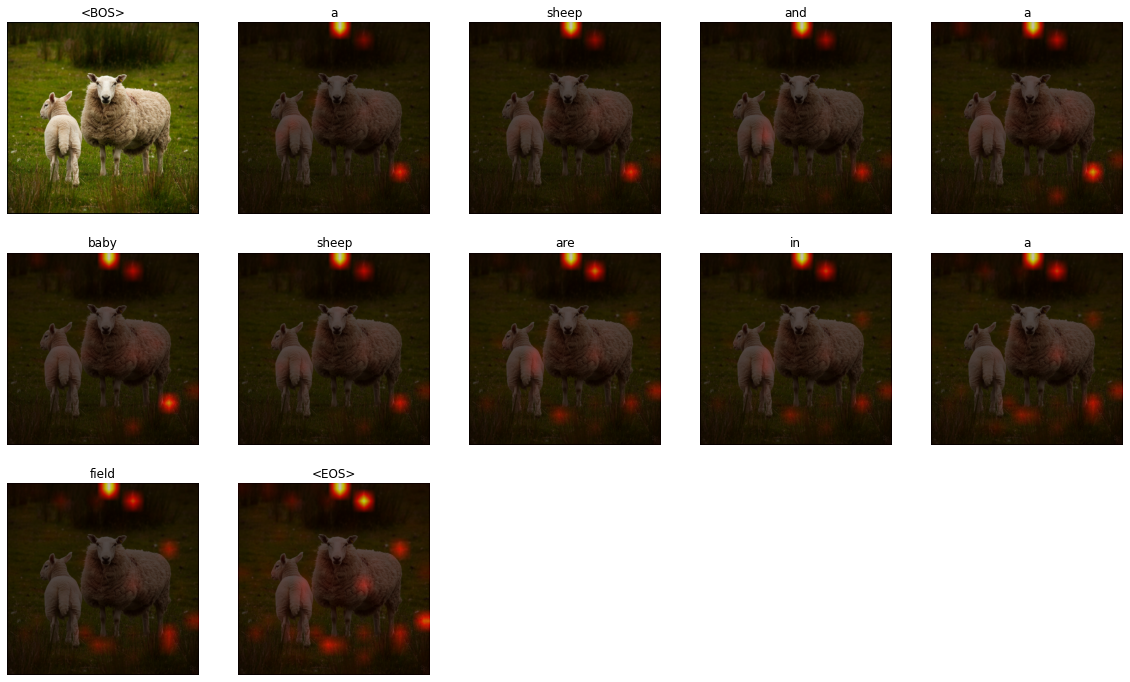

 60%|██████    | 3/5 [00:05<00:03,  1.81s/it]

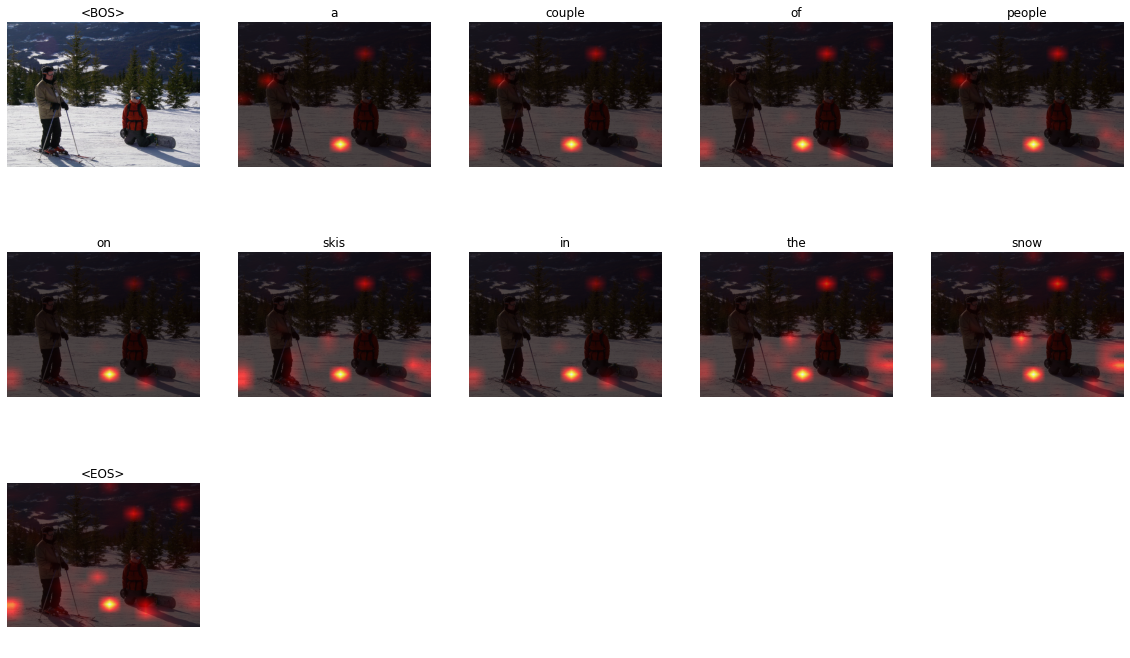

 80%|████████  | 4/5 [00:07<00:01,  1.74s/it]

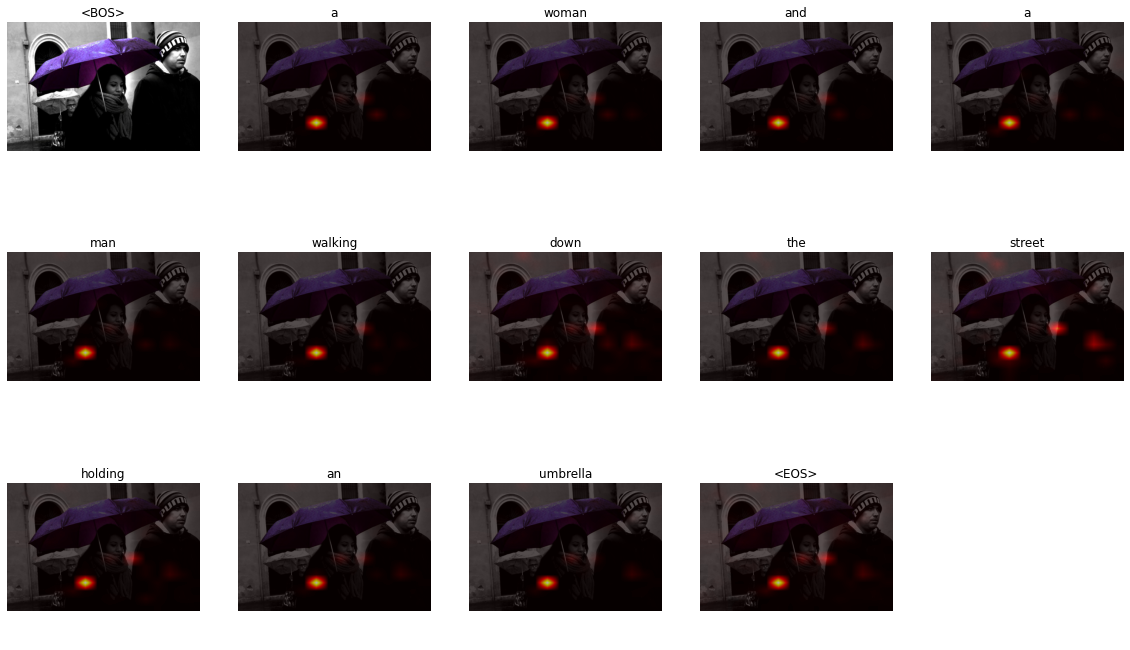

100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


In [37]:
import cv2

model = Transformer(model=model_vit.visual).type(torch.FloatTensor).to(device)
model.load_state_dict(torch.load(os.path.join(arg['save_dir'], 'model2.pth')))
model.type(torch.FloatTensor).to(device)
model.eval()
for k, batch in enumerate(tqdm(val_loader)):
    img = batch.to(device)
    x_patch = torch.ones(1, 256).to(device)
    memory = model.encoder(img)
    ys = torch.zeros(1, 1).long().to(device)
    ys[:] = 2
    max_len = 64
    ans = []
    for l in range(max_len-1):
        y_patch = torch.zeros(1, ys.shape[1]).to(device)
        with torch.no_grad():
            out, attn_weight = model.decoder(ys, memory, x_patch, y_patch, subsequent_mask(ys.shape[1]).to(device))
            out = model.out(out[:, -1])
        next_word = out.argmax(dim=-1).item()
        ans.append(next_word)
        ys = torch.cat([ys, torch.empty(1, 1).type_as(ys.data).fill_(next_word)], dim=1).to(device)
        if next_word == 13:
            break
    result = tokenizer.decode(ans)

    img_gt = Image.open(files_name[k]).convert('RGB')
    m, n = img_gt.size
    result = ['<BOS>', *result.split()[:-1], '<EOS>']
    word_len = len(result)
    ncols = 5
    nrows = int(math.ceil(word_len/ncols))
    attn_weight = attn_weight.squeeze(0)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))        
    for i in range(nrows):
        for j in range(ncols):
            tmp = ax[i][j]
            idx = i*ncols + j
            if idx < word_len:
                if idx == 0:
                    tmp.set_title(result[idx])
                    tmp.imshow(img_gt)
                else:
                    tmp.set_title(result[idx])
                    tmp.imshow(img_gt)
                    attn = attn_weight[idx-1].reshape((-1, 16)).cpu().numpy()
                    attn = cv2.resize(attn, (int(m), int(n)))
                    # attn = attn - np.min(attn)
                    attn = np.uint8(attn * 255 / np.max(attn))
                    tmp.imshow(attn, alpha=0.7, cmap='hot')
            tmp.axis('off')
    plt.show()